 ## Intro
 For info on basemap module see:                                            
 http://basemaptutorial.readthedocs.io/en/latest/                           
 Author of this code: Peter Kongstad - kongstad25@gmail.com - November 2017 
 Note it is build for python 2.6 and will not work correctly on python 3+   

In [1]:
#%% Imported modules
import ephem
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import urllib2
from datetime import datetime
import math

Import the TLE from celesttrack website

The following lines contain the category numbers for different satellites

#39430 This is for GomX1
#25544 This is for ISS
#41866 This is for GOES
#41765 This is for Tiangong 2

In [2]:
#Imports the raw html code with the TLE information from celestrak website
response = urllib2.urlopen('https://www.celestrak.com/cgi-bin/TLE.pl?CATNR=25544') # This is for ISS
data = response.read()

In [3]:
#Clean up its output, removing html code
sep = '</P'
data2 = str(data.split(sep, 1)[0])
sep = 'RE>'
cleaned = str(data2.split(sep, 1)[1])
print cleaned


ISS (ZARYA)             
1 25544U 98067A   17333.24922317  .00003053  00000-0  53117-4 0  9999
2 25544  51.6431 295.4569 0004020 162.0436 334.7941 15.54254223 87425



In [4]:
#Crudely, but effectively select the TLE bits needed from the string
name=cleaned[1:15] #Scoops out the satellite name
line1=cleaned[26:95] #Strips the first line of the TLE
line2=cleaned[96:165] #Strips the second line of the TLE


Using the ephem module to decipher the TLE information

In [5]:
#Using the TLE of the satellite to compute paramters
tle_rec = ephem.readtle(name, line1, line2)
tle_rec.compute()

#Calculate the altitude of the satellite in km's above Earth surface
altitude=tle_rec.elevation/1000

#Calculate it's velocity
velocity=math.sqrt((6.67*10**-11)*(5.98*10**24)/(6.38*10**6)+(altitude))

# This part prints the TLE data as longitude/latitude, altitucde, velocity and spatial resolution.
print "Current information for:", name;
print "Longitude:", tle_rec.sublong;
print "Latitude:", tle_rec.sublat;
print "Altitude:" , tle_rec.elevation/1000, "[km]";
print "Velocity:",velocity/1000, "[km/s]";
print "Spatial Resolution of current altitude with the 35 mm lens:"
print  ((tle_rec.elevation/1000)/650)*60, "[pixels pr. m]";

Current information for: ISS (ZARYA)   
Longitude: 84:24:18.4
Latitude: 49:58:26.7
Altitude: 408.6544375 [km]
Velocity: 7.90686982773 [km/s]
Spatial Resolution of current altitude with the 35 mm lens:
37.7219480769 [pixels pr. m]


Prepare data for basemap mapping.

In [6]:
#Make the longitude and lattitude a string/variable for basemap operation
x_long=str(tle_rec.sublong)
x_lat=str(tle_rec.sublat)

#Remove the excess numbers past first colon due to basemap limitations of
#understanding latitude and longitude coordinates on both 3D and 2D map.
sep = ':'
ylattr = str(x_lat.split(sep, 1)[0])
ylongr = str(x_long.split(sep, 1)[0])

## Basemap operations

There was a lot of issues with getting both 3D and 2D map to work based on the lat/long. Therefore I have different type of variables for it to work

3D Globe map

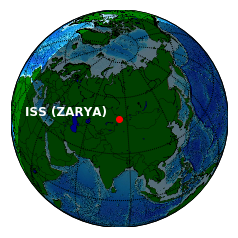

In [10]:
#The 3D Globe map
#Map perspective is set from the current lat/long of the satellite.
fig = plt.figure(1)
map = Basemap(projection='ortho',lon_0=ylongr,lat_0=ylattr,resolution='l')
map.etopo() #Sets the graphics for the globe, different options on basemap site
map.drawcoastlines(linewidth=0.25)
map.drawcountries(linewidth=0.25)
map.fillcontinents(color='green',lake_color='blue')
map.drawmapboundary(fill_color='aqua')
map.drawmeridians(np.arange(0,360,30))
map.drawparallels(np.arange(-90,90,30))

#This part plots the satellite as a red dot and with text, needs direct input of lonlat
sat_lon,sat_lat=map(ylongr,ylattr)
map.plot(sat_lon,sat_lat,marker='o',color='r')
plt.text(sat_lon,sat_lat, name,fontsize=12,fontweight='bold',ha='right',va='bottom',color='w')

#Paints a grid
nlats = 73; nlons = 145; delta = 2.*np.pi/(nlons-1)
lats = (0.5*np.pi-delta*np.indices((nlats,nlons))[0,:,:])
lons = (delta*np.indices((nlats,nlons))[1,:,:])
wave = 0.75*(np.sin(2.*lats)**8*np.cos(4.*lons))
mean = 0.5*np.cos(2.*lats)*((np.sin(2.*lats))**2 + 2.)
x, y = map(lons*180./np.pi, lats*180./np.pi)
date = datetime.utcnow()
CS=map.nightshade(date)
#plt.title('Globe View') Decrepated and frankly not needed
plt.show()

2D Flat map

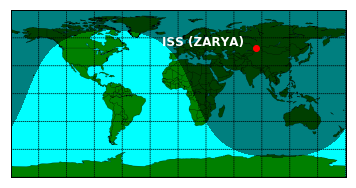

In [13]:
fig = plt.figure(2)
map = Basemap(projection='cyl')
map.drawcoastlines(linewidth=0.25)
map.drawcountries(linewidth=0.25)
map.fillcontinents(color='green',lake_color='aqua')
map.drawmapboundary(fill_color='aqua')
map.drawmeridians(np.arange(0,360,30))
map.drawparallels(np.arange(-90,90,30))

#Need to convert the string with lat/long to an integer for flat map to work
ylongri=int(ylongr);
ylattri=int(ylattr);
sat_lon,sat_lat=map(ylongri,ylattri)
map.plot(sat_lon,sat_lat,marker='o',color='r')
plt.text(sat_lon,sat_lat,name,fontsize=12,fontweight='bold',ha='right',va='bottom',color='w')
date = datetime.utcnow()
CS=map.nightshade(date)
#plt.title('Flat Map View') Decrepated and frankly not needed
plt.show()